# Iteration 23: Multiple Replications (2) stage 2

## Plain English Summary

The second step of implementing multiple replications writes new code only:

1. Create a multiple replications function that calls `single_run` and stores run results.
2. Create three functions for combining replications and calculating the mean of the occupancy and prob of delay distributions
3. Create a function that produces a table summary of "probability of delay" and "1 in every n patients delayed" (to match paper).

These are standard python functions that are relatively simple we therefore included all of functions in the same prompt.

> The tester writes the script to run all of these functions.
> 
> To simplify the notebook we remove the scripts to run ASU and Rehab models individually using scripts. Models are still tested individually in the formal testing section.

## Notebook imports

In [2]:
from IPython.display import Markdown, display, HTML
import math
import statistics
from sim_tools.distributions import Lognormal
import numpy as np
import pandas as pd

## LLM Prompt 1 <a class="anchor" id="llm_prompt"></a>

In [3]:
display(Markdown("../01_perplexity/inputs/23_iteration.md"))

create a function called `multiple_replications`. The function accepts an instance of `Experiment` and the number of replications (default=5) as parameters. The functions logic of each replication is as follows:

1. call `single_run` 
2. store the returned results of the replication for later use in a list called `rep_results`

after all replications are complete return `rep_results`


create a function called `combine_pdelay_results(rep_results)` where `rep_results` is a python list where each item is a dictionary.  The function logic is as follows:

Loop through `rep_results`:

1. select `prob_delay_asu` and `unique_vals_asu`.
2. find the minimum value in `unique_vals_asu` called `min_occupancy_asu`
3. Create an new array of length 30 of all zeros.  Copy values from `prob_delay_asu` to the new array using `unique_vals_asu` as the index.
4. In the new array set all values whose array index is < `min_occupancy` to 1.0
5. store the results a new result list

Repeat for `prob_delay_rehab`, `unique_vals_rehab` and `min_occupancy_rehab`
Return the result lists in a tuple of numpy arrays


create a function called `combine_occup_results(rep_results)` where `rep_results` is a python list where each item is a dictionary.  The function logic is as follows:

Loop through `rep_results`:

1. select `relative_freq_asu` and `unique_vals_asu`.
2. Create an new array of length 30 of all zeros.  Copy values from `relative_freq_asu` to the new array using `unique_vals_asu` as the index.
3. store the results a new result list

Repeat for `relative_freq_rehab`,
Return the result lists in a tuple of numpy arrays



create a function called `mean_results(rep_results)` where `rep_results` is a numpy array. The function should return the mean of the columns in rep_results.


create a function called `summary_table(mean_pdelay, min_beds, max_beds, bed_type)`. 
1. Slice `mean_pdelay` between `min_beds` and `max_beds`.
2. Creates a pandas dataframe. The first column is the slice of `mean_pdelay` (2dp) the second column is 1 / the slice of `mean_pdelay` (to 2dp).  Round the 2nd column down to nearest integer.
3. The column names are "p(delay)" and "1 in every n patients delayed".
4. The index should start at min_beds and end at max_beds.  Its name is "No. " + `bed_type` + " beds"
5.  Return the dataframe


## Date and time of input to LLM

> 0900 23rd July 2024

## Observations on the LLM Output

* An initial prompt was used in this iteration to convert lognormal moments to normal moments and use it in the `RehabilitationUnit` class.
* This is added to the testing function
* The ASU continues to use the conversion method in the `PatientType` class
* This iteration generated all new functions using the Stage 1 prompt. These are all listed below.
* (TOTAL TWO PROMPTS)


## Sources reported by the LLM

* None reported at time of generation.

## Code carried over 

*  `calculate_occupancy_frequencies` - calculate relative frequencies of occupancy observations
*  `occupancy_plot` - show occupancy as a bar chart.
*  `calculate_prob_delay`
*  `prob_delay_plot`
*  `Experiment`
*  `PatientType` - ASU patient types
*  `RehabilitationUnit`
*  `AcuteStrokeUnit`
*  `single_run` - code that runs the full model ASU+REHAB

## Model code <a class="anchor" id="model_code"></a>

### Imports

In [4]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

### LLM Output: lognormal function

In [5]:
def lognormal_to_normal(mean, std):
    """
    Convert lognormal moments to normal moments.
    
    Parameters:
    mean (float): Mean of the lognormal distribution.
    std (float): Standard deviation of the lognormal distribution.
    
    Returns:
    tuple: (mean, std) of the corresponding normal distribution.
    """
    normal_mean = np.log(mean ** 2 / np.sqrt(std ** 2 + mean ** 2))
    normal_std = np.sqrt(np.log(std ** 2 / mean ** 2 + 1))
    return normal_mean, normal_std

### Experiment class

In [6]:
class Experiment:
    def __init__(self, params=None):
        default_params = {
            'results_collection_period': 5 * 365,
            'warm_up': 1095,  # Added here, immediately below results_collection_period
            'trace': False,
            'acute_audit_interval': 1,  # Default to 1 day
            'rehab_audit_interval': 1,  # Default to 1 day
            'rehab_stroke_iat': 21.8,
            'rehab_neuro_iat': 31.7,
            'rehab_other_iat': 28.6,
            # New parameters for RehabilitationUnit
            'rehab_stroke_esd_los_mean': 30.3,
            'rehab_stroke_esd_los_std': 23.1,
            'rehab_stroke_other_los_mean': 28.4,
            'rehab_stroke_other_los_std': 27.2,
            'rehab_complex_neuro_los_mean': 27.6,
            'rehab_complex_neuro_los_std': 28.4,
            'rehab_other_los_mean': 16.1,
            'rehab_other_los_std': 14.1,
            'rehab_stroke_post_destination_probs': [0.4, 0.6],
            'rehab_complex_neuro_post_destination_probs': [0.09, 0.91],
            'rehab_other_post_destination_probs': [0.12, 0.88],
            'patient_types': {
                'Stroke': {
                    'interarrival_time': 1.2,
                    'post_asu_probabilities': [0.24, 0.13, 0.63],
                    'los_params': {'Rehab': (7.4, 8.6), 'ESD': (4.6, 4.8), 'Other': (7.0, 8.7)}
                },
                'TIA': {
                    'interarrival_time': 9.3,
                    'post_asu_probabilities': [0.01, 0.01, 0.98],
                    'los_params': (1.8, 5.0)
                },
                'Complex Neurological': {
                    'interarrival_time': 3.6,
                    'post_asu_probabilities': [0.11, 0.05, 0.84],
                    'los_params': (4.0, 5.0)
                },
                'Other': {
                    'interarrival_time': 3.2,
                    'post_asu_probabilities': [0.05, 0.10, 0.85],
                    'los_params': (3.8, 5.2)
                }
            }
        }

        if params is None:
            self.params = default_params
        else:
            self.params = self.merge_params(default_params, params)

        self.asu_occupancy = []  # Initialize the list to store ASU occupancy
        self.rehab_occupancy = []  # Initialize the list to store rehab occupancy
        self.warm_up = self.params['warm_up']  # Initialize warm_up period from params

    def merge_params(self, default, new):
        merged = default.copy()
        for key, value in new.items():
            if isinstance(value, dict) and key in merged:
                merged[key] = self.merge_params(merged[key], value)
            else:
                merged[key] = value
        return merged

    def audit_acute_occupancy(self, env, first_interval, audit_interval, asu, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.asu_occupancy.append(asu.occupancy)
            yield env.timeout(audit_interval)

    def audit_rehab_occupancy(self, env, first_interval, audit_interval, rehab_unit, experiment):
        yield env.timeout(first_interval)
        while True:
            experiment.rehab_occupancy.append(rehab_unit.occupancy)
            yield env.timeout(audit_interval)

    def reset_kpi(self):
        self.asu_occupancy = []
        self.rehab_occupancy = []


### ASU Patient Type Class

In [7]:
class PatientType:
    def __init__(self, name, interarrival_time, post_asu_probabilities, los_params):
        self.name = name
        self.interarrival_time = interarrival_time
        self.count = 0
        self.rng = np.random.default_rng()
        self.post_asu_probabilities = post_asu_probabilities
        self.los_params = los_params

    def generate_interarrival_time(self):
        return self.rng.exponential(self.interarrival_time)

    def sample_post_asu_destination(self):
        return self.rng.choice(['Rehab', 'ESD', 'Other'], p=self.post_asu_probabilities)

    def sample_length_of_stay(self, destination=None):
        if self.name == 'Stroke':
            mean, std = self.los_params[destination]
        else:
            mean, std = self.los_params

        normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
        normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))

        return self.rng.lognormal(normal_mean, normal_std)

### Acute stroke unit class

In [8]:
class AcuteStrokeUnit:
    def __init__(self, env, experiment, rehab_unit):
        self.env = env
        self.experiment = experiment
        self.rehab_unit = rehab_unit
        #self.results_collection_period = experiment.params['results_collection_period']
        self.total_arrivals = 0
        self.occupancy = 0
        self.trace = experiment.params['trace']
        self.patient_types = {
            name: PatientType(name, params['interarrival_time'], params['post_asu_probabilities'], params['los_params'])
            for name, params in experiment.params['patient_types'].items()
        }

    def run(self):
        for patient_type in self.patient_types.values():
            self.env.process(self.patient_generator(patient_type))

    def patient_generator(self, patient_type):
        while True:
            interarrival_time = patient_type.generate_interarrival_time()
            yield self.env.timeout(interarrival_time)
            self.total_arrivals += 1
            patient_type.count += 1
            patient_id = self.total_arrivals - 1
            post_asu_destination = patient_type.sample_post_asu_destination()
            if self.trace:
                print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) arrived")
                print(f" Total arrivals: {self.total_arrivals}")
                print(f" {patient_type.name} arrivals: {patient_type.count}")
                print(f" Post-ASU destination: {post_asu_destination}")
                print(f" Next {patient_type.name} arrival in {interarrival_time:.2f} days")
            self.occupancy += 1
            if self.trace:
                print(f" Current occupancy: {self.occupancy}")
            self.env.process(self.acute_treatment(patient_type, patient_id, post_asu_destination))

    def acute_treatment(self, patient_type, patient_id, post_asu_destination):
        if patient_type.name == 'Stroke':
            yield from self.stroke_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'TIA':
            yield from self.tia_acute_treatment(patient_type, patient_id, post_asu_destination)
        elif patient_type.name == 'Complex Neurological':
            yield from self.complex_neurological_acute_treatment(patient_type, patient_id, post_asu_destination)
        else:  # Other
            yield from self.other_acute_treatment(patient_type, patient_id, post_asu_destination)
        self.occupancy -= 1
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type.name}) left ASU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = self.patient_types['Stroke'].sample_length_of_stay(post_asu_destination)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (stroke to stroke rehab): {post_asu_destination, patient_id}")

    def tia_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (tia to tia rehab): {post_asu_destination, patient_id}")

    def complex_neurological_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (complex to complex rehab): {post_asu_destination, patient_id}")

    def other_acute_treatment(self, patient_type, patient_id, post_asu_destination):
        los = patient_type.sample_length_of_stay()
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) starting acute treatment")
            print(f" Length of stay: {los:.2f} days")
        yield self.env.timeout(los)
        if self.trace:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) finished acute treatment")
        if post_asu_destination == "Rehab":
            self.rehab_unit.occupancy += 1
            self.rehab_unit.arrivals_from_asu +=1
            self.env.process(self.rehab_unit.rehab_treatment(patient_type, patient_id))
            if self.trace:
                print(f" Post-ASU destination (other to other rehab): {post_asu_destination, patient_id}")

### Rehabilitation Unit class <a class="anchor" id="iteration_code_a"></a>

In [9]:
class RehabilitationUnit:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        self.trace = experiment.params['trace']
        self.total_arrivals = 0
        self.arrivals_from_asu = 0
        self.patient_counts = {
            'Stroke': 0,
            'Complex Neurological': 0,
            'Other': 0,
            'TIA': 0
        }
        self.occupancy = 0
        self.stroke_iat_external = experiment.params['rehab_stroke_iat']
        self.complex_neuro_iat_external = experiment.params['rehab_neuro_iat']
        self.other_iat_external = experiment.params['rehab_other_iat']

        # Convert lognormal moments to normal moments
        self.stroke_esd_mean, self.stroke_esd_std = lognormal_to_normal(
            experiment.params['rehab_stroke_esd_los_mean'],
            experiment.params['rehab_stroke_esd_los_std']
        )
        self.stroke_other_mean, self.stroke_other_std = lognormal_to_normal(
            experiment.params['rehab_stroke_other_los_mean'],
            experiment.params['rehab_stroke_other_los_std']
        )
        self.complex_neuro_mean, self.complex_neuro_std = lognormal_to_normal(
            experiment.params['rehab_complex_neuro_los_mean'],
            experiment.params['rehab_complex_neuro_los_std']
        )
        self.other_mean, self.other_std = lognormal_to_normal(
            experiment.params['rehab_other_los_mean'],
            experiment.params['rehab_other_los_std']
        )
        self.tia_mean, self.tia_std = lognormal_to_normal(18.7, 23.5)  # TIA parameters

    def run(self):
        self.env.process(self.stroke_generator())
        self.env.process(self.complex_neuro_generator())
        self.env.process(self.other_generator())

    def stroke_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.stroke_iat_external))
            self.patient_arrival('Stroke')

    def complex_neuro_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.complex_neuro_iat_external))
            self.patient_arrival('Complex Neurological')

    def other_generator(self):
        while True:
            yield self.env.timeout(np.random.exponential(self.other_iat_external))
            self.patient_arrival('Other')

    def patient_arrival(self, patient_type):
        patient_id = self.total_arrivals
        self.total_arrivals += 1
        self.patient_counts[patient_type] += 1
        self.occupancy += 1

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) arrived at RU")
            print(f" Total arrivals: {self.total_arrivals}")
            print(f" {patient_type} arrivals: {self.patient_counts[patient_type]}")
            print(f" Current patient counts: {self.patient_counts}")
            print(f" Current occupancy: {self.occupancy}")

        self.env.process(self.rehab_treatment(patient_type, patient_id))

    def rehab_treatment(self, patient_type, patient_id):
        if patient_type == 'Stroke':
            yield from self.stroke_rehab_treatment(patient_id)
        elif patient_type == 'Complex Neurological':
            yield from self.complex_neurological_rehab_treatment(patient_id)
        elif patient_type == 'TIA':
            yield from self.tia_rehab_treatment(patient_id)
        else:
            yield from self.other_rehab_treatment(patient_id)

        self.occupancy -= 1
        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} ({patient_type}) left RU")
            print(f" Current occupancy: {self.occupancy}")

    def stroke_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_stroke_post_destination_probs'])

        if post_rehab_destination == 'ESD':
            length_of_stay = np.random.lognormal(self.stroke_esd_mean, self.stroke_esd_std)
        else:
            length_of_stay = np.random.lognormal(self.stroke_other_mean, self.stroke_other_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Stroke) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def complex_neurological_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_complex_neuro_post_destination_probs'])

        length_of_stay = np.random.lognormal(self.complex_neuro_mean, self.complex_neuro_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Complex Neurological) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def other_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=self.experiment.params['rehab_other_post_destination_probs'])

        length_of_stay = np.random.lognormal(self.other_mean, self.other_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (Other) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")

    def tia_rehab_treatment(self, patient_id):
        post_rehab_destination = np.random.choice(['ESD', 'Other'], p=[0, 1])  # Always 'Other' for TIA patients

        length_of_stay = np.random.lognormal(self.tia_mean, self.tia_std)

        yield self.env.timeout(length_of_stay)

        if self.experiment.params['trace']:
            print(f"Time {self.env.now:.2f}: Patient {patient_id} (TIA) completed rehab treatment")
            print(f" Post-rehab destination: {post_rehab_destination}")
            print(f" Length of stay: {length_of_stay:.2f} days")


### Occupancy post-processing code

In [10]:
def calculate_occupancy_frequencies(occupancy_list):
    unique_values, counts = np.unique(occupancy_list, return_counts=True)
    relative_freq = counts / len(occupancy_list)
    cumulative_freq = np.cumsum(relative_freq)
    return relative_freq, cumulative_freq, unique_values

In [11]:
def occupancy_plot(relative_freq, unique_values, x_label="No. people in ward", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(unique_values, relative_freq)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Relative Frequency")
    ax.set_title("Occupancy Distribution")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    return fig, ax

### Probability of delay post-processing code

In [12]:
def calculate_prob_delay(relative_freq, cumulative_freq):
    rel_freq = np.array(relative_freq)
    cum_freq = np.array(cumulative_freq)
    return rel_freq / cum_freq

In [13]:
def prob_delay_plot(prob_delay, unique_values, x_label="No. acute beds available", figsize=(12, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.step(unique_values, prob_delay, where='post')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Probability of Delay")
    ax.set_title("Probability of Delay vs. Number of Beds Available")
    ax.set_xticks(range(0, 31))
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1)
    return fig, ax

## Function to perform a single run of ASU+REHAB

In [14]:
def single_run(experiment):
    experiment.reset_kpi()

    # Create the simulation environment
    env = simpy.Environment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Run models
    rehab_unit.run()
    asu.run()

    # Start the audit processes
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, experiment.params['acute_audit_interval'], asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, experiment.params['rehab_audit_interval'], rehab_unit, experiment))

    # Run the simulation
    env.run(until=experiment.warm_up + experiment.params['results_collection_period'])

    # Calculate occupancy frequencies and probabilities of delay
    rel_freq_a, cum_freq_a, unique_vals_a = calculate_occupancy_frequencies(experiment.asu_occupancy)
    prob_delay_a = calculate_prob_delay(rel_freq_a, cum_freq_a)

    rel_freq_r, cum_freq_r, unique_vals_r = calculate_occupancy_frequencies(experiment.rehab_occupancy)
    prob_delay_r = calculate_prob_delay(rel_freq_r, cum_freq_r)

    return {
        'relative_freq_asu': rel_freq_a,
        'prob_delay_asu': prob_delay_a,
        'unique_vals_asu': unique_vals_a,
        'relative_freq_rehab': rel_freq_r,
        'prob_delay_rehab': prob_delay_r,
        'unique_vals_rehab': unique_vals_r
    }


### Multiple Replication function

In [15]:
def multiple_replications(experiment, num_replications=5):
    rep_results = []
    for _ in range(num_replications):
        result = single_run(experiment)
        rep_results.append(result)
    return rep_results


### Functions to combine replication results

In [16]:
def combine_pdelay_results(rep_results):
    asu_results = []
    rehab_results = []

    for result in rep_results:
        prob_delay_asu = result['prob_delay_asu']
        unique_vals_asu = result['unique_vals_asu']
        min_occupancy_asu = min(unique_vals_asu)

        asu_array = np.zeros(30)
        asu_array[unique_vals_asu] = prob_delay_asu
        asu_array[:min_occupancy_asu] = 1.0
        asu_results.append(asu_array)

        prob_delay_rehab = result['prob_delay_rehab']
        unique_vals_rehab = result['unique_vals_rehab']
        min_occupancy_rehab = min(unique_vals_rehab)

        rehab_array = np.zeros(30)
        rehab_array[unique_vals_rehab] = prob_delay_rehab
        rehab_array[:min_occupancy_rehab] = 1.0
        rehab_results.append(rehab_array)

    return np.array(asu_results), np.array(rehab_results)


In [17]:
def combine_occup_results(rep_results):
    asu_results = []
    rehab_results = []

    for result in rep_results:
        relative_freq_asu = result['relative_freq_asu']
        unique_vals_asu = result['unique_vals_asu']

        asu_array = np.zeros(30)
        asu_array[unique_vals_asu] = relative_freq_asu
        asu_results.append(asu_array)

        relative_freq_rehab = result['relative_freq_rehab']
        unique_vals_rehab = result['unique_vals_rehab']

        rehab_array = np.zeros(30)
        rehab_array[unique_vals_rehab] = relative_freq_rehab
        rehab_results.append(rehab_array)

    return np.array(asu_results), np.array(rehab_results)


In [18]:
def mean_results(rep_results):
    return np.mean(rep_results, axis=0)

### Tabular results for p(delay)

In [19]:
def summary_table(mean_pdelay, min_beds, max_beds, bed_type):
    sliced_pdelay = mean_pdelay[min_beds:max_beds+1]
    data = {
        "p(delay)": np.round(sliced_pdelay, 2),
        "1 in every n patients delayed": np.floor(1 / np.round(sliced_pdelay, 2)).astype(int)
    }
    df = pd.DataFrame(data, index=range(min_beds, max_beds+1))
    df.index.name = f"No. {bed_type} beds"
    return df


> Script to run model was outputted by LLM along with the prompt outputs

> Min and max beds in summary table were modified by tester

ASU Summary Table:

Rehab Summary Table:


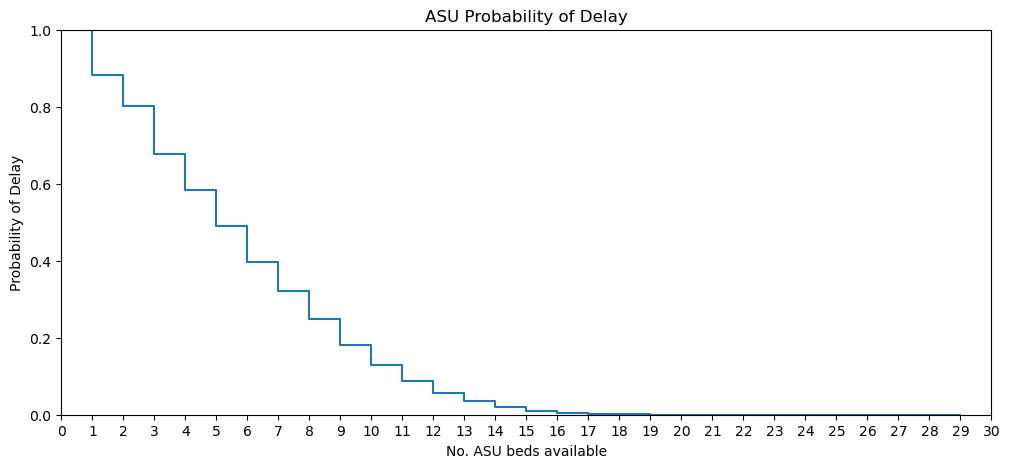

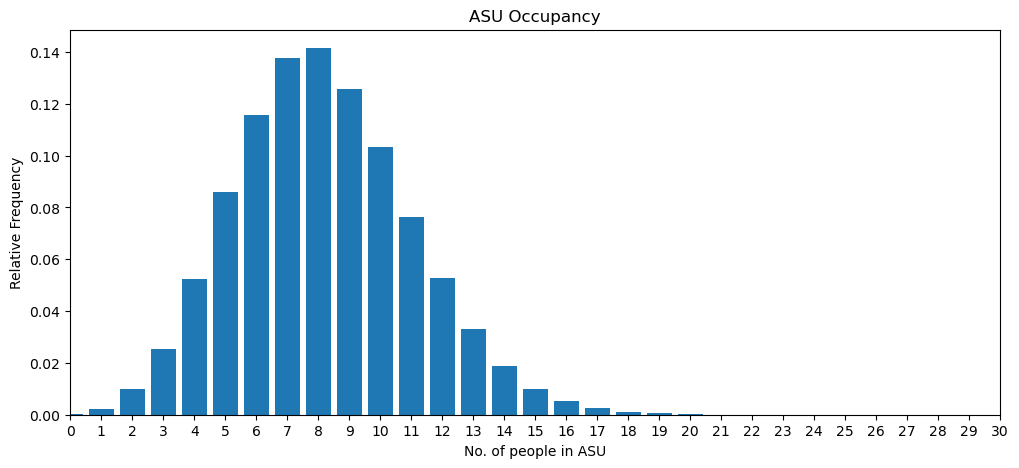

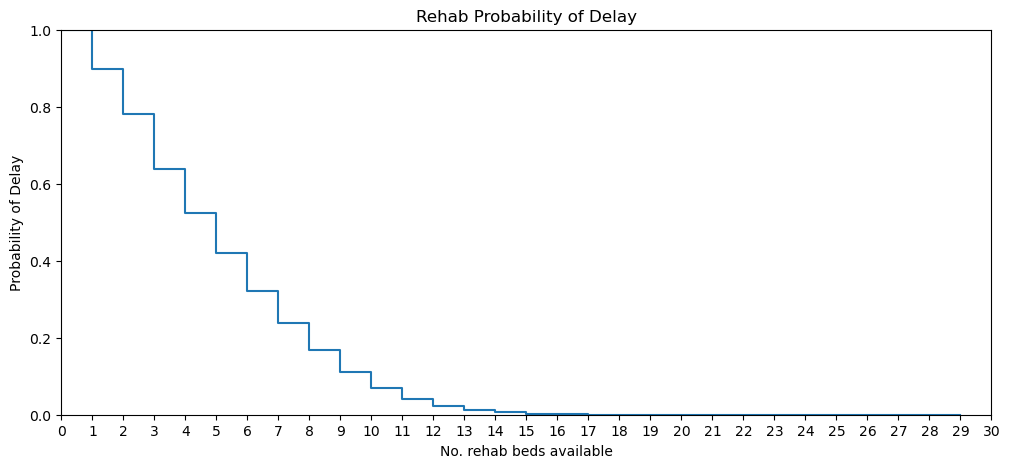

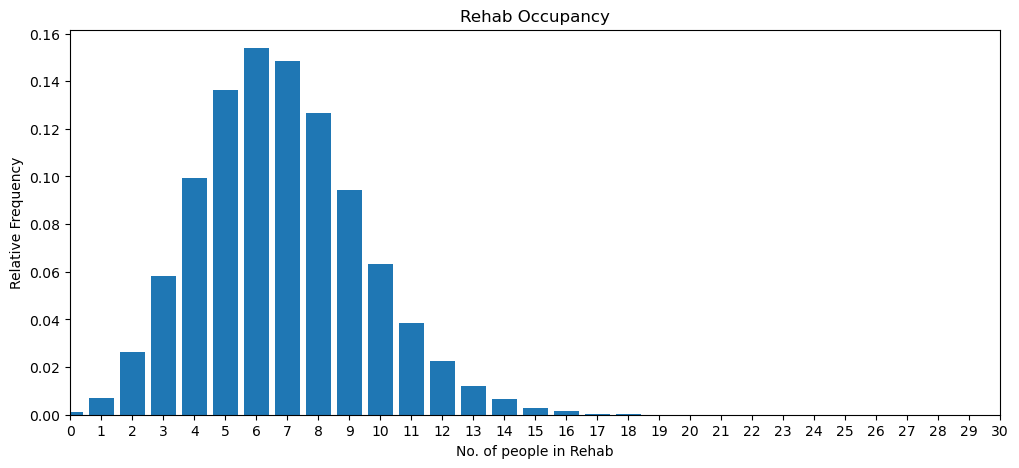

In [29]:

# Create the experiment
experiment = Experiment({
    'results_collection_period': 365*5,  # Run for 5 years
    'trace': False,  # Set to True if you want to see detailed logs
})

# Run multiple replications
rep_results = multiple_replications(experiment, num_replications=100)

# Combine results
asu_pdelay, rehab_pdelay = combine_pdelay_results(rep_results)
asu_occup, rehab_occup = combine_occup_results(rep_results)

# Calculate mean results
mean_pdelay_asu = mean_results(asu_pdelay)
mean_pdelay_rehab = mean_results(rehab_pdelay)
mean_occup_asu = mean_results(asu_occup)
mean_occup_rehab = mean_results(rehab_occup)

# Create summary tables
asu_summary = summary_table(mean_pdelay_asu, min_beds=9, max_beds=14, bed_type="ASU")
rehab_summary = summary_table(mean_pdelay_rehab, min_beds=8, max_beds=14, bed_type="Rehab")

# Plot ASU Probability of Delay
fig, ax = prob_delay_plot(mean_pdelay_asu, range(30), x_label="No. ASU beds available")
plt.title("ASU Probability of Delay")
plt.show()

# Plot ASU Occupancy
fig, ax = occupancy_plot(mean_occup_asu, range(30), x_label="No. of people in ASU")
plt.title("ASU Occupancy")
plt.show()

# Plot Rehab Probability of Delay
fig, ax = prob_delay_plot(mean_pdelay_rehab, range(30), x_label="No. rehab beds available")
plt.title("Rehab Probability of Delay")
plt.show()

# Plot Rehab Occupancy
fig, ax = occupancy_plot(mean_occup_rehab, range(30), x_label="No. of people in Rehab")
plt.title("Rehab Occupancy")
plt.show()


In [30]:
print("ASU Summary Table:")
asu_summary

ASU Summary Table:


,p(delay),1 in every n patients delayed
No. ASU beds,,
9,0.18,5
10,0.13,7
11,0.09,11
12,0.06,16
13,0.03,33
14,0.02,50


In [32]:
print("Rehab Summary Table:")
rehab_summary

Rehab Summary Table:


,p(delay),1 in every n patients delayed
No. Rehab beds,,
8,0.17,5
9,0.11,9
10,0.07,14
11,0.04,25
12,0.02,50
13,0.01,100
14,0.01,100


## Testing <a class="anchor" id="testing_code"></a>
* **Results processing 1**: code correctly calculates relative and cumulative frequencies
    * Expected result: for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
    * Actual result (PASS): for [1, 1, 1, 1, 2, 2, 2, 3, 3, 4] relative = [4/10, 3/10, 2/10, 1/10] and cum = [4/10, 7/10, 9/10, 1.0]
* **Results processing 2**: test that prob delay is calculated correctly.
    * Expected result: The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
    * Actual result (PASS): The probability of delay is [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
* **Results collection test 1**: Test the result collection process for ASU collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 2**: Test ASU ward occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to 50 with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are in the range 0 to 50 with sensible moments.
* **Results collection test 3**: Test the result collection process for REHAB collects unit occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Results collection test 4**: Test REHAB unit occupancy data collected is in a sensible range.
    * Expected result: The type collected is int. The values are in the range 0 to (10-15) with sensible moments.
    * Actual result (PASS):  The type collected is int. The values are 0 to (10-15) with sensible moments.
* **Results collection test 5**: **SYSTEM TEST**: Test the result collection process for ASU+REHAB collects ward occupancy every day
    * Expected result: The number of observations taken is 1 less the number of days the model is run.
    * Actual result (PASS):  The number of observations taken is 1 less the number of days the model is run.
* **Single run test**: **SYSTEM TEST**: Test that the `single_run` function returns a dictionary of results
  * Expected Result: len(run_results) == 6 and type(run_results) == dict
  * Actual Result (PASS): len(run_results) == 6 and type(run_results) == dict
* **Warm-up Period Test**: Test warm-up works correctly for ASU+REHAB ward occupancy. Audit interval = 1 and Warm-up > 0
    * Expected result: The length of the occupancy data collection arrays is equal to the results collection period.
    * Actual result (PASS): The length of the occupancy data collection arrays is equal to the results collection period.
* **Suppress simulated trace**: Test that setting experiment.trace = False suppresses ASU output by default.
    * Expected result: The ASU model runs with no simulated log output
    * Actual result (PASS): The ASU model runs with no simulated log output
* **Suppress simulated trace 2**: Test that setting experiment.trace = False suppresses REHAB output by default.
    * Expected result: The REHAB model runs with no simulated log output
    * Actual result (PASS): The REHAB model runs with no simulated log output
* **Testing lognormal function**: Test that lognomal function correctly calculates the moments of the underlying normal dist.
    * Expected result: The LLM generated function and `sim-tools.distributions.Lognormal` perform the same conversion.
    * Actual results (PASS):  The functions generate the same values.
* **Extreme value test 1**: TIA, Complex Neuro, Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the model is "Stroke"
* **Extreme value test 2**: All patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Different run length**: The run length of the model is set to 10 days.
    * Expected result: The model should runs no longer than 10 simulated time periods
    * Actual result (PASS): The model runs no longer than 10 simulated time periods
* **Extreme value test 3**: All patient types have have their mean length of stay time set to $M$ a very large number
    * Expected result: No patients depart the model (only arrivals seen in log)
    * Actual Results (PASS): No patients depart the model.
* **Extreme value test 4**: All patient types apart from stroke->rehab have have their mean length of stay time set to $M$ a very large number
    * Expected result: Only stroke patients depart the model (seen in log)
    * Actual Results (PASS): Only stroke patient depart the model.
* **Extreme value test 5**: In rehab, Complex Neuro, and Other, have their inter-arrival time is set to $M$ a very large number
    * Expected result: The only type of patient to arrive to the rehab model is "Stroke"
    * Actual result (PASS): The only type of patient to arrive to the rehab model is "Stroke"
* **Extreme value test 6**: In the rehab model, all patient types have have their inter-arrival time is set to $M$ a very large number
    * Expected result: No patients arrive to the model.
    * Actual result (PASS): No patients arrive to the model.
* **Extreme value test 7**: In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.
    * Expected result: Patients arrive to the model as normal, but do not depart.
    * Actual result (PASS): Patients arrive to the model as normal, but do not depart.

### Results processing 1

Test that the code correctly calculates the relative and cumulative frequencies of a python list of integer values.

(PASS)

In [33]:
def result_processing_test_1(values, rel_expected, cum_expected):
    '''
    Test the `calculate_occupancy_frequencies` function works
    as expected.

    Expected result: relative frequencies and cumulative freqs
    are the same as expected values.

    Params:
    ------
    values: list
        list of values to test

    rel_expected: list
        list of floats - expected relative freqs

    cum_expected: list
        list of floats - expected cumulative freqs

    Returns:
    -------
    bool: does the model pass the test.
    '''
    rel, cum, unique = calculate_occupancy_frequencies(values)
    # use all close to allow for minor floating point differences.
    return (set(rel) == set(rel_expected)) and  np.allclose(np.array(cum_expected), cum)

In [34]:
result_processing_test_1(values=[1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
                         rel_expected=[0.4, 0.3, 0.2, 0.1],
                         cum_expected=[0.4, 0.7, 0.9, 1.0])

True

### Results Processing test 2

Test that the calculation of the probability of delay is correct.

(PASS)

In [35]:
def result_processing_test_2(relative, cum, p_delay_expected):
    '''
    Test the probability of delay is calculated correctly.
    
    Params:
    ------
    relative: list
        list of floats - relative freqs

    cum: list
        list of floats - cumulative freqs

    Returns:
    -------
    bool: does the function pass the test.
    '''
    p_delay = calculate_prob_delay(relative, cum)
    # use all close to allow for minor floating point differences.
    return np.allclose(np.array(p_delay_expected), p_delay)

In [36]:
relative = [0.4, 0.3, 0.2, 0.1],
cum = [0.4, 0.7, 0.9, 1.0]
expected = [1.0, 0.3/0.7, 0.2/0.9, 0.1/1.0]
result = result_processing_test_2(relative, cum, expected)
result

True

### Results collection test 1

Test the optional results collection process works correctly.  The process should collect acute stroke occupancy every day

(PASS)

In [37]:
def results_collection_test1(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: len(experiment.asu_occupancy) == env.now

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment
    experiment = Experiment({
        'run_length': 365*5,  # Run for 5 years
        'trace': False,  # Set to True if you want to see detailed logs
        'acute_audit_interval': audit_interval  # Audit interval as specified
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)

    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # modified iteration 21
    # start the audit_acute_occupancy to record ASU occupancy at intervals
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model - modified iteration 21
    asu.run()
    env.run(until=experiment.params['results_collection_period'])

    print(f"Number of occupancy audits: {len(experiment.asu_occupancy)}")
    print(f'Simulation time: {env.now}')
    
    # The number of audits should be equal to the simulation time
    # (assuming audit_interval=1 and the first audit happens at time 1)
    return len(experiment.asu_occupancy) == (env.now - 1)


In [38]:
results_collection_test1()

Number of occupancy audits: 1824
Simulation time: 1825


True

### Result collection test 2

(PASS)

In [39]:
def results_collection_test2(audit_interval=1):
    '''
    Test ASU ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 0 to 50 with sensible moments.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''

    # Create the experiment
    experiment = Experiment({
        'trace': False,
        'acute_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()

    rehab_unit = RehabilitationUnit(env, experiment)


    # Create the AcuteStrokeUnit
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))

    # Run the model - modified iteration 21
    asu.run()
    env.run(until=experiment.params['results_collection_period'])

    # Calculate statistics
    min_occupancy = min(experiment.asu_occupancy)
    max_occupancy = max(experiment.asu_occupancy)
    mean_occupancy = statistics.fmean(experiment.asu_occupancy)
    deciles = [round(q, 1) for q in statistics.quantiles(experiment.asu_occupancy, n=10)]

    # Print results
    print(f'Minimum occupancy: {min_occupancy}')
    print(f'Maximum occupancy: {max_occupancy}')
    print(f'Mean occupancy: {mean_occupancy:.2f}')
    print(f'Deciles of occupancy: {deciles}')


In [40]:
results_collection_test2()

Minimum occupancy: 0
Maximum occupancy: 18
Mean occupancy: 8.13
Deciles of occupancy: [4.0, 6.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


### Results collection test 3

Test the optional results collection process works correctly for rehab.  The process should collect rehab unit occupancy every day.

(PASS)


In [41]:
def results_collection_test3(audit_interval=1):
    '''
    Test the model collects rehab occupancy every day

    Expected result: len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()

    # create experiment
    experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, experiment)

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    
    # Run the model for the default run length in the experiment - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])
    
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    return len(experiment.rehab_occupancy) == (env.now - 1)

In [42]:
results_collection_test3()

len(experiment.rehab_occupancy)=1824
env.now=1825


True

## Results Collection Test 4

(PASS)

In [43]:
def results_collection_test4(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range.
    
    Expected result: The type collected is int. The values are in 
    the range 1 to [10-15] with sensible moments.

    Note this is when the Rehab unit is used independently
    with external arrivals only i.e. no transfers from ASU.

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    None
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # create experiment
    experiment = Experiment()
    
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    
    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    
    # Run the model for the default run length in the experiment - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])
    
    print(f'min(experiment.rehab_occupancy)={min(experiment.rehab_occupancy)}')
    print(f'max(experiment.rehab_occupancy)={max(experiment.rehab_occupancy)}')
    print(f'statistics.fmean(experiment.rehab_occupancy)={statistics.fmean(experiment.rehab_occupancy):.2f}')
    print('Deciles:', [round(q, 1) for q in statistics.quantiles(experiment.rehab_occupancy, n=10)])


In [44]:
results_collection_test4()

min(experiment.rehab_occupancy)=0
max(experiment.rehab_occupancy)=8
statistics.fmean(experiment.rehab_occupancy)=2.75
Deciles: [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 5.0]


### Results Collection Test 5 (SYSTEM TEST)

Test that when the models are linked that the occupancy is audited correctly.

In [45]:
def results_collection_test5(audit_interval=1):
    '''
    Test REHAB ward occupancy data collected is in a sensible range
    when it is connected to the ASU model.
    
    Expected result: The type collected is int. The values are in 
    the range in the range 1 to [10-15] with sensible moments.

    Expected result: 
        len(experiment.asu_occupancy) == env.now - 1 AND
        len(experiment.rehab_occupancy) == env.now - 1

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))
    
    # Run the simulation until the specified run length in the Experiment parameters - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])

    # Print info for debug
    print(f"Average rehab occupancy: {sum(experiment.rehab_occupancy) / len(experiment.rehab_occupancy):.2f}")
    print(f"Maximum rehab occupancy: {max(experiment.rehab_occupancy)}")
    print(f"Minimum rehab occupancy: {min(experiment.rehab_occupancy)}")
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')

    # Test
    return len(experiment.asu_occupancy) == (env.now - 1) and \
           len(experiment.rehab_occupancy) == (env.now - 1)


In [46]:
results_collection_test5()

Average rehab occupancy: 6.82
Maximum rehab occupancy: 17
Minimum rehab occupancy: 0
len(experiment.asu_occupancy)=1824
len(experiment.rehab_occupancy)=1824
env.now=1825


True

### Results Collection Test 6 (SYSTEM TEST)


In [51]:
def results_collection_test6(audit_interval=1):
    '''
    Test the model collects acute stroke occupancy every day

    Expected result: The type collected is int. The values are in 
    the range in the range 1 to ~25 with sensible moments.

    Note this is when the Rehab unit is linked to the ASU.
    I.e. transfers from ASU + external arrivals

    prints out:
    min
    max
    mean
    deciles

    Params:
    ------
    audit_interval: 1
        duration of audit.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Create an experiment with default parameters
    experiment = Experiment()

    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()

    # Start the audit process - modified iteration 21
    env.process(experiment.audit_rehab_occupancy(env, 1, experiment.params['rehab_audit_interval'], rehab_unit, experiment))
    env.process(experiment.audit_acute_occupancy(env, 1, experiment.params['acute_audit_interval'], asu, experiment))
    
    # Run the simulation until the specified run length in the Experiment parameters - modified in iteration 21
    env.run(until=experiment.params['results_collection_period'])

    # Test
    print(f'min(experiment.rehab_occupancy)={min(experiment.rehab_occupancy)}')
    print(f'max(experiment.rehab_occupancy)={max(experiment.rehab_occupancy)}')
    print(f'statistics.fmean(experiment.rehab_occupancy)={statistics.fmean(experiment.rehab_occupancy):.2f}')
    print('Deciles:', [round(q, 1) for q in statistics.quantiles(experiment.rehab_occupancy, n=10)])



In [52]:
results_collection_test6()

min(experiment.rehab_occupancy)=0
max(experiment.rehab_occupancy)=15
statistics.fmean(experiment.rehab_occupancy)=7.06
Deciles: [4.0, 5.0, 6.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0]


### Warm-up Test

(PASS)

In [53]:
def warm_up_test(warm_up, audit_interval=1):
    '''
    Test warm-up works correctly for ASU+REHAB ward occupancy

    Expected result: 
        len(experiment.asu_occupancy) == experiment.params['results_collection_period'] 
        AND len(experiment.rehab_occupancy) == experiment.params['results_collection_period'] 

    Params:
    ------
    warm_up: int
        Duration of warm-up period.
    audit_interval: int, default 1
        Duration of audit interval.

    Returns:
    -------
    bool: does the model pass the test.
    '''
    # Create the experiment with specified warm-up period
    experiment = Experiment({
        'warm_up': warm_up,
        'acute_audit_interval': audit_interval,
        'rehab_audit_interval': audit_interval
    })

    # Create the simulation environment
    env = simpy.Environment()
    
    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators
    asu.run()

    # Start the REHAB patient generators
    rehab_unit.run()

    # Start the audit processes
    env.process(experiment.audit_acute_occupancy(env, experiment.warm_up, audit_interval, asu, experiment))
    env.process(experiment.audit_rehab_occupancy(env, experiment.warm_up, audit_interval, rehab_unit, experiment))
    
    # Run the simulation
    env.run(until=experiment.warm_up + experiment.params['results_collection_period'])

    # Print info for debug
    print(f'{len(experiment.asu_occupancy)=}')
    print(f'{len(experiment.rehab_occupancy)=}')
    print(f'{env.now=}')
    print(f'{experiment.params["results_collection_period"]=}')
    print(f'{experiment.warm_up + experiment.params["results_collection_period"]=}')

    # Test
    return (len(experiment.asu_occupancy) == experiment.params['results_collection_period'] and 
            len(experiment.rehab_occupancy) == experiment.params['results_collection_period'])


In [54]:
warm_up_test(warm_up=365)

len(experiment.asu_occupancy)=1825
len(experiment.rehab_occupancy)=1825
env.now=2190
experiment.params["results_collection_period"]=1825
experiment.warm_up + experiment.params["results_collection_period"]=2190


True

### Single run test (SYSTEM TEST)

In [55]:
def single_run_test():
    '''
    Test the single_run function returns a dictionary of 
    results.

    The results dictionary contains the following keys:

    'relative_freq_asu'
    'prob_delay_asu'
    'unique_vals_asu'
    'relative_freq_rehab'
    'prob_delay_rehab'
    'unique_vals_rehab'

    Expected result: 
        len(run_results) == 6 and type(run_results) == dict

    Returns:
    -------
    bool: does the model pass the test.
    '''

    # a default experiment
    default_experiment_params = Experiment()

    # run the model
    run_results = single_run(default_experiment_params)

    # Print the results for debugging
    print(f"{run_results['relative_freq_asu']=}")
    print(f"{run_results['prob_delay_asu']=}")
    print(f"{run_results['unique_vals_asu']=}")
    print(f"{run_results['relative_freq_rehab']=}")
    print(f"{run_results['prob_delay_rehab']=}")
    print(f"{run_results['unique_vals_rehab']=}")

    # Test
    expected_keys = {
        'relative_freq_asu',
        'prob_delay_asu',
        'unique_vals_asu',
        'relative_freq_rehab',
        'prob_delay_rehab',
        'unique_vals_rehab'
    }

    return len(run_results) == 6 and type(run_results) == dict and set(run_results.keys()) == expected_keys


In [56]:
single_run_test()

run_results['relative_freq_asu']=array([0.00054795, 0.00164384, 0.00712329, 0.0230137 , 0.04164384,
       0.08438356, 0.09753425, 0.13479452, 0.13863014, 0.12876712,
       0.11616438, 0.09150685, 0.06410959, 0.03068493, 0.02082192,
       0.01205479, 0.00493151, 0.00164384])
run_results['prob_delay_asu']=array([1.        , 0.75      , 0.76470588, 0.71186441, 0.56296296,
       0.53287197, 0.38115632, 0.34502104, 0.26190476, 0.19567027,
       0.15003539, 0.1056962 , 0.0689452 , 0.03194524, 0.0212172 ,
       0.01213458, 0.00493963, 0.00164384])
run_results['unique_vals_asu']=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])
run_results['relative_freq_rehab']=array([0.0060274 , 0.01972603, 0.03506849, 0.08712329, 0.14191781,
       0.19616438, 0.1769863 , 0.13972603, 0.07616438, 0.05424658,
       0.03123288, 0.01863014, 0.00767123, 0.00712329, 0.00219178])
run_results['prob_delay_rehab']=array([1.        , 0.76595745, 0.57657658, 0.58888889, 0.489

True

## Test suppress trace 1

(PASS)

In [57]:
def test_suppress_log(trace):
    '''
    Test that setting experiment.trace 
    False suppresses output.

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''

    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    model = AcuteStrokeUnit(env, experiment, rehab_unit)
    model.run()
    env.run(until=experiment.params['results_collection_period'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    for patient_type in model.patient_types.values():
        print(f"Total {patient_type.name} arrivals: {patient_type.count}")



In [58]:
test_suppress_log(trace=False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 2850
Total Stroke arrivals: 1521
Total TIA arrivals: 183
Total Complex Neurological arrivals: 546
Total Other arrivals: 600


### Test suppress trace 2

In [59]:
def test_suppress_log_rehab(trace):
    '''
    Test that setting experiment.trace to
    False suppresses output in the rehab model

    Expected result: patient_count > 0

    Params:
    ------
    trace: bool
        is trace outputted or not?

    Returns:
    -------
    int: number of patient arrivals.
    '''
    # Create the simulation environment


    experiment = Experiment({'trace': trace})
    env = simpy.Environment()
    model = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, model)
    model.run()
    env.run(until=experiment.params['results_collection_period'])
    
    print("\nSimulation completed.")
    print(f"Total simulation time: {model.env.now:.2f} days")
    print(f"Total patient arrivals: {model.total_arrivals}")
    print(f"Final rehab patient counts: {model.patient_counts}")


In [60]:
test_suppress_log_rehab(False)


Simulation completed.
Total simulation time: 1825.00 days
Total patient arrivals: 212
Final rehab patient counts: {'Stroke': 96, 'Complex Neurological': 52, 'Other': 64, 'TIA': 0}


### Lognormal test

Test that lognomal function correctly calculates the moments of the underlying normal dist.

**Result: PASS**

In [65]:
def test_lognormal_moments(mean, std):
    '''
    Test that lognomal function correctly calculates 
    the moments of the underlying normal dist.

    Params:
    ------
    mean: float
        mean of the lognormal distribution

    std: float
        st dev of the lognormal distribution

    Returns:
    -------
    bool
    '''
   
    # Lognormal class from sim-tools.
    expected_moments = Lognormal(mean, std)
    print(expected_moments.mu, expected_moments.sigma)

    # Convert lognormal parameters from llm for asu
    normal_mean = math.log(mean**2 / math.sqrt(std**2 + mean**2))
    normal_std = math.sqrt(math.log(1 + (std**2 / mean**2)))
    print(normal_mean, normal_std)

    # Check llm lognormal function used in rehab model - changed in iteration 23
    normal_mean2 = np.log(mean ** 2 / np.sqrt(std ** 2 + mean ** 2))
    normal_std2 = np.sqrt(np.log(std ** 2 / mean ** 2 + 1))
    print (normal_mean2, normal_std2)


    return (normal_mean, normal_std) == (expected_moments.mu, expected_moments.sigma) == (normal_mean2, normal_std2)

In [66]:
test_lognormal_moments(128.79, 267.51)

4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718
4.022977459259615 1.2924439729790718


True

### Extreme value test 1

The model uses hard coded parameters.  The most simple way to modify the code for this test was to change hard coded parameters for $M$

**Result: PASS**

In [67]:
M = 10_000_000

In [68]:
def ev_test_1(large_number):
    '''
    TIA, Complex Neuro, Other, have their inter-arrival 
    time set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the model 
    is "Stroke". This is seen in the event log

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, results_collection_period=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': 1.2},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, results_collection_period=2*365)  # Run for 2 years with custom parameters


In [69]:
ev_test_1(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 612
Total Stroke arrivals: 612
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Extreme value test 2

* An experiment is setup so that all patient types have a mean inter-arrival rate of $M$

**Result: PASS**

In [70]:
def ev_test_2(large_number):
    '''
    All patient types have have their inter-arrival time is 
    set to $M$ a very large number
    
    Expected result: No patients arrive to the model.
    
    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    int: the number of patients that arrived to the model.
    '''

    def main(arrival_rates=None, results_collection_period=None):
        custom_params = {}
        
        if arrival_rates:
            custom_params['patient_types'] = arrival_rates
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    
    if __name__ == "__main__":
        large_number = M
        
        asu_arrival_rates = {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        }
    
    main(asu_arrival_rates, results_collection_period=2*365)  # Run for 2 years with custom parameters


In [71]:
ev_test_2(M)


Simulation completed.
Total simulation time: 730.00 days
Total patient arrivals: 0
Total Stroke arrivals: 0
Total TIA arrivals: 0
Total Complex Neurological arrivals: 0
Total Other arrivals: 0


### Different run length test

The model has again been modified to use the original code and parameters generated by the LLM.

In [72]:
TEN_DAYS = 10

In [73]:
def test_run_length(results_collection_period):
    '''
    Test that the run length of the model can be modified.
    
    Expected result: The model should runs no longer than the new run length.

    Params:
    ------
    run_length: float
        Run length of the model in days.

    Returns:
    -------
    float
        Simulation end time.
    '''
    def main(results_collection_period=None):
        custom_params = {}
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)

        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results to check
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")
    if __name__ == "__main__":
        main(results_collection_period=results_collection_period)


In [74]:
test_run_length(TEN_DAYS)


Simulation completed.
Total simulation time: 10.00 days
Total patient arrivals: 13
Total Stroke arrivals: 10
Total TIA arrivals: 2
Total Complex Neurological arrivals: 0
Total Other arrivals: 1


### Extreme value test 3

* An experiment is setup so that all patient types have a mean length of stay on the ASU of $M$

**Result: PASS**

In [75]:
def ev_test_3(large_number):
    '''
    All patient types have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: No patients depart the model 
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    def main(los_params=None, results_collection_period=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period

        
        if trace:
            custom_params['trace'] = True
            
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (large_number, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, results_collection_period=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals == final_occupancy

In [77]:
result = ev_test_3(M)

Time 0.57: Patient 0 (Stroke) arrived
 Total arrivals: 1
 Stroke arrivals: 1
 Post-ASU destination: Other
 Next Stroke arrival in 0.57 days
 Current occupancy: 1
Time 0.57: Patient 0 (Stroke) starting acute treatment
 Length of stay: 9999992.43 days
Time 1.22: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 2
 Post-ASU destination: Other
 Next Stroke arrival in 0.65 days
 Current occupancy: 2
Time 1.22: Patient 1 (Stroke) starting acute treatment
 Length of stay: 10000007.24 days
Time 1.51: Patient 2 (Stroke) arrived
 Total arrivals: 3
 Stroke arrivals: 3
 Post-ASU destination: ESD
 Next Stroke arrival in 0.29 days
 Current occupancy: 3
Time 1.51: Patient 2 (Stroke) starting acute treatment
 Length of stay: 9999999.87 days
Time 3.32: Patient 3 (Stroke) arrived
 Total arrivals: 4
 Stroke arrivals: 4
 Post-ASU destination: Other
 Next Stroke arrival in 1.81 days
 Current occupancy: 4
Time 3.32: Patient 3 (Stroke) starting acute treatment
 Length of stay: 10000000.86 days


In [78]:
result

True

### Extreme value test 4

* An experiment is setup so that all patient types other than stroke->rehab have a mean length of stay on the ASU of $M$

**Result: PASS**

In [79]:
def ev_test_4(large_number):
    '''
    All patient types apart from stroke-rehab patients
    have have their mean length 
    of stay time set to $M$ a very large number
    
    Expected result: Only stroke patients depart the
    model.
    (only arrivals seen in log)

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    
    def main(los_params=None, results_collection_period=None, trace=True):
        custom_params = {'patient_types': {}}
        
        if los_params:
            for patient_type, los in los_params.items():
                if patient_type not in custom_params['patient_types']:
                    custom_params['patient_types'][patient_type] = {}
                custom_params['patient_types'][patient_type]['los_params'] = los
        
        if results_collection_period:
            custom_params['results_collection_period'] = results_collection_period

        if trace:
            custom_params['trace'] = True
    
        # Create an Experiment instance with custom parameters
        experiment = Experiment(custom_params)
    
        # Run the simulation with the custom experiment
        env = simpy.Environment()
        rehab_unit = RehabilitationUnit(env, experiment)
        model = AcuteStrokeUnit(env, experiment, rehab_unit)
        model.run()
        env.run(until=experiment.params['results_collection_period'])
    
        # Print results
        print("\nSimulation completed.")
        print(f"Total simulation time: {model.env.now:.2f} days")
        print(f"Total patient arrivals: {model.total_arrivals}")
        print(f"Total occupancy: {model.occupancy}")
        for patient_type in model.patient_types.values():
            print(f"Total {patient_type.name} arrivals: {patient_type.count}")

        return model  # Return the model so we can access its attributes

    # New length of stay parameters - stdev is default
    new_los_params = {
        'Stroke': {'Rehab': (7.4, 8.6), 'ESD': (large_number, 4.8), 'Other': (large_number, 8.7)},
        'TIA': (large_number, 5.0),
        'Complex Neurological': (large_number, 5.0),
        'Other': (large_number, 5.2)
    }

    # Run the simulation with new parameters
    model = main(los_params=new_los_params, results_collection_period=2*365)

    # Check if the total number of arrivals is greater than the final occupancy
    total_arrivals = model.total_arrivals
    final_occupancy = model.occupancy

    return total_arrivals > final_occupancy


In [81]:
results = ev_test_4(M)

Time 0.14: Patient 0 (Stroke) arrived
 Total arrivals: 1
 Stroke arrivals: 1
 Post-ASU destination: Other
 Next Stroke arrival in 0.14 days
 Current occupancy: 1
Time 0.14: Patient 0 (Stroke) starting acute treatment
 Length of stay: 9999998.75 days
Time 0.47: Patient 1 (Stroke) arrived
 Total arrivals: 2
 Stroke arrivals: 2
 Post-ASU destination: Other
 Next Stroke arrival in 0.33 days
 Current occupancy: 2
Time 0.47: Patient 1 (Stroke) starting acute treatment
 Length of stay: 9999984.14 days
Time 1.67: Patient 2 (Stroke) arrived
 Total arrivals: 3
 Stroke arrivals: 3
 Post-ASU destination: Other
 Next Stroke arrival in 1.20 days
 Current occupancy: 3
Time 1.67: Patient 2 (Stroke) starting acute treatment
 Length of stay: 10000014.61 days
Time 2.44: Patient 3 (Other) arrived
 Total arrivals: 4
 Other arrivals: 1
 Post-ASU destination: Other
 Next Other arrival in 2.44 days
 Current occupancy: 4
Time 2.44: Patient 3 (Other) starting acute treatment
 Length of stay: 9999995.61 days
Tim

In [82]:
results

True

### Extreme value test 5

Only stroke arrivals to the Rehab unit

(PASS)

In [83]:
def ev_test_5(large_number):
    '''
    Complex Neuro, Other, have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: The only type of patient to arrive to the rehab model 
    is "Stroke". This is verified by the patient counts variables in the model.

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': False,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': 21.8,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    # Check if only Stroke patients arrived
    return rehab_unit.patient_counts['Stroke'] == rehab_unit.total_arrivals

    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [84]:
ev_test_5(M)

Patient counts:
  Stroke: 92
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 92


True

### Extreme Value test 6

No arrivals to the rehab unit.

(PASS)

In [85]:
def ev_test_6(large_number):
    '''
    All patients have their rehab inter-arrival 
    time is set to $M$ a very large number
    
    Expected result: No patients will arrive in the model

    Notes:
    ------
    This test will need to be modified when the hardcoded parameters
    are migrated to the Experiment class. 

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: rehab_unit.stroke_count == rehab_unit.patient_count
    
    '''

    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_iat': large_number,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")
    
    print(f"Total arrivals: {rehab_unit.total_arrivals}")


In [86]:
ev_test_6(M)

Patient counts:
  Stroke: 0
  Complex Neurological: 0
  Other: 0
  TIA: 0
Total arrivals: 0
Total arrivals: 0


### Extreme value test 7

In the rehab model, all patient types have their length of stay means set to $M$ a very larger number.

(PASS)

In [87]:
def ev_test_7(large_number):
    '''
    All patient types have have their mean length 
    of stay time in REHAB set to $M$ a very large number
    
    Expected result: No patients depart the rehab model 
    Evaluated from the trace of the simulation model

    Notes:
    -----
    This test can be improved when occupancy of rehab is measured.

    It will also need to be modified when TIA treatment is added.

    Params:
    -------
    large_number: int
        M a very large number 
    '''
    # Create the simulation environment
    experiment = Experiment({
        'trace': True,  # Set to True if you want to see detailed logs
        'rehab_stroke_esd_los_mean': large_number,
        'rehab_stroke_other_los_mean': large_number,
        'rehab_complex_neuro_los_mean': large_number,
        'rehab_other_los_mean': large_number
    })
    env = simpy.Environment()
    rehab_unit = RehabilitationUnit(env, experiment)
    rehab_unit.run()
    env.run(until=experiment.params['results_collection_period'])

    # Print out stats collected
    print(f"Patient counts:")
    for patient_type, count in rehab_unit.patient_counts.items():
        print(f"  {patient_type}: {count}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

    print(f"Total arrivals: {rehab_unit.total_arrivals}")

In [95]:
ev_test_7(M)

Time 1.55: Patient 0 (Stroke) arrived at RU
 Total arrivals: 1
 Stroke arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 0, 'Other': 0, 'TIA': 0}
 Current occupancy: 1
Time 4.38: Patient 1 (Other) arrived at RU
 Total arrivals: 2
 Other arrivals: 1
 Current patient counts: {'Stroke': 1, 'Complex Neurological': 0, 'Other': 1, 'TIA': 0}
 Current occupancy: 2
Time 4.44: Patient 2 (Stroke) arrived at RU
 Total arrivals: 3
 Stroke arrivals: 2
 Current patient counts: {'Stroke': 2, 'Complex Neurological': 0, 'Other': 1, 'TIA': 0}
 Current occupancy: 3
Time 7.76: Patient 3 (Stroke) arrived at RU
 Total arrivals: 4
 Stroke arrivals: 3
 Current patient counts: {'Stroke': 3, 'Complex Neurological': 0, 'Other': 1, 'TIA': 0}
 Current occupancy: 4
Time 14.10: Patient 4 (Stroke) arrived at RU
 Total arrivals: 5
 Stroke arrivals: 4
 Current patient counts: {'Stroke': 4, 'Complex Neurological': 0, 'Other': 1, 'TIA': 0}
 Current occupancy: 5
Time 27.85: Patient 5 (Stroke) arriv

### Extreme value test 8 (SYSTEM TEST)

Set all inter-arrival times - asu and rehab to $M$. Where $M$ is a very large number.

In [96]:
def ev_test_8(large_number):
    '''
    All patient types have their ASU and REHAB inter-arrival 
    time set to $M$, a very large number
    
    Expected result: No patients arrive to the model
    This is verified by the patient count variables in the model.

    Params:
    -------
    large_number: int
        M a very large number 

    Returns:
    --------
    bool: All patient counts in both ASU and Rehab unit are zero
    '''
    # Create the simulation environment
    env = simpy.Environment()
    
    # Set all inter-arrival times to a large number
    experiment_params = {
        'run_length': 365,  # Run for 1 year
        'trace': False,
        'patient_types': {
            'Stroke': {'interarrival_time': large_number},
            'TIA': {'interarrival_time': large_number},
            'Complex Neurological': {'interarrival_time': large_number},
            'Other': {'interarrival_time': large_number}
        },
        'rehab_stroke_iat': large_number,
        'rehab_neuro_iat': large_number,
        'rehab_other_iat': large_number
    }
    
    # Create experiment
    experiment = Experiment(experiment_params)
    
    # Create models
    rehab_unit = RehabilitationUnit(env, experiment)
    asu = AcuteStrokeUnit(env, experiment, rehab_unit)
    
    # Start the ASU patient generators for each type of patient
    asu.run()
    rehab_unit.run()
    
    # Run the simulation
    env.run(until=experiment.params['run_length'])

    # Print out stats collected
    print(f'ASU total arrivals: {asu.total_arrivals}')
    print(f'Rehab total arrivals: {rehab_unit.total_arrivals}')
    for patient_type, count in asu.patient_types.items():
        print(f'ASU {patient_type} count: {count.count}')
    print(f'Rehab patient counts: {rehab_unit.patient_counts}')
    print(f'ASU occupancy: {asu.occupancy}')
    print(f'Rehab occupancy: {rehab_unit.occupancy}')
    
    # Check if all patient counts are zero
    asu_zero = all(pt.count == 0 for pt in asu.patient_types.values())
    rehab_zero = all(count == 0 for count in rehab_unit.patient_counts.values())


In [97]:
ev_test_8(M)

ASU total arrivals: 0
Rehab total arrivals: 0
ASU Stroke count: 0
ASU TIA count: 0
ASU Complex Neurological count: 0
ASU Other count: 0
Rehab patient counts: {'Stroke': 0, 'Complex Neurological': 0, 'Other': 0, 'TIA': 0}
ASU occupancy: 0
Rehab occupancy: 0
